In [157]:
import numpy as np
import pandas as pd
import surprise
from surprise import BaselineOnly
from surprise import SVD
import random
from surprise.model_selection import cross_validate, KFold
import datetime
import time
from tabulate import tabulate
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv(r"C:\Users\sydne\Desktop\Springboard\BIS Cap\Data\sampled_df.csv")


In [3]:
data.head()

,User-ID,Location,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,142121,"waipahu, hawaii, usa",0345372050,10,You Just Don't Understand,DEBORAH TANNEN,1991,Ballantine Books
1,191728,"victoria, british columbia, canada",0671004107,5,Contact,Carl Sagan,1997,Pocket
2,196148,"aylmer, québec, canada",2203001054,8,L'Oreille Cassee / The Broken Ear (Tintin),Herge,1999,Casterman
3,154811,"mooresville, indiana, usa",0440226430,6,Summer Sisters,Judy Blume,1999,Dell Publishing Company
4,136686,"toronto, ontario, canada",0968677657,8,The Tangled Boy,Caro Soles,2002,Baskerville Books


### Create a reader to load in surprise object

In [42]:
reader = surprise.Reader(rating_scale=(1,10))

## Create the surprise object

#### create a mapping item of book titles to ISBN

In [45]:
book_title_map = dict(zip(data['ISBN'], data['Book-Title']))

In [46]:
data_surprise = surprise.Dataset.load_from_df(data[['User-ID', 'ISBN', 'Book-Rating']],reader)
print(type(data_surprise))

<class 'surprise.dataset.DatasetAutoFolds'>


In [47]:
data_surprise.df.head()

,User-ID,ISBN,Book-Rating
0,142121,0345372050,10
1,191728,0671004107,5
2,196148,2203001054,8
3,154811,0440226430,6
4,136686,0968677657,8


# Check SVD against baseline algorithm (defeault Alternating Least Sqaures)

In [100]:
np.random.seed(0)
random.seed(0)

In [101]:
kf = KFold(random_state=0)

In [102]:
algos = (SVD(random_state=0), BaselineOnly())

In [103]:
dataset = 'Sampled data'

In [104]:
stable = "https://surprise.readthedocs.io/en/stable/"

In [105]:
LINK = {"SVD": "[{}]({})".format(
        "SVD",
        stable
        + "matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD",
    ),"BaselineOnly": "[{}]({})".format(
        "Baseline",
        stable
        + "basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly",
    )}

In [85]:
table = []
for algo in algos:
    start = time.time()
    out = cross_validate(algo, data_surprise, ["rmse", "mae"], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    link = LINK[algo.__class__.__name__]
    mean_rmse = "{:.3f}".format(np.mean(out["test_rmse"]))
    mean_mae = "{:.3f}".format(np.mean(out["test_mae"]))

    new_line = [link, mean_rmse, mean_mae, cv_time]
    print(tabulate([new_line], tablefmt="pipe"))  # print current algo perf
    table.append(new_line)

header = [ "RMSE", "MAE", "Time"]
print(tabulate(table, header, tablefmt="pipe"))

|:-----------------------------------------------------------------------------------------------------------------------------------|------:|-----:|:--------|
| [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) | 1.694 | 1.32 | 0:00:11 |
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
|:--------------------------------------------------------------------------------------------------------------------------------------|------:|------:|:--------|
| [Baseline](https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly) | 1.706 | 1.339 | 0:00:05 |
|                                                                                                                                       |   RMSE |   MAE | Time    |
|:------------------------------

### Using SIngle Value Decomposition

In [86]:
train, test = surprise.model_selection.train_test_split(data_surprise, 0.2)

In [87]:
svd= surprise.SVD()

In [115]:
svd.fit(train)

In [116]:
predictions = svd.test(test)

In [117]:
rmse = surprise.accuracy.rmse(predictions)
mae = surprise.accuracy.mae(predictions)

RMSE: 1.7034
MAE:  1.3206


### Try to hypertune model

In [91]:
params_SVD = {
    'lr_all': [0.005, 0.002, 0.001, 0.0005],
    'n_factors': [20, 50, 75, 125, 150, 250],
    'reg_all': [0.005, 0.01, 0.015, 0.02, 0.03, 0.05],
    'n_epochs': [10, 20, 30, 50, 70, 100]
}

In [92]:
tuning_svd = surprise.model_selection.search.RandomizedSearchCV(algo_class=surprise.SVD, param_distributions = params_SVD,
                   cv=5
                   )

In [93]:
tuning_svd.fit(data=data_surprise)

In [94]:
best_params_svd = tuning_svd.best_params['rmse']
tuning_svd.best_params['rmse']

{'lr_all': 0.002, 'n_factors': 50, 'reg_all': 0.03, 'n_epochs': 50}

In [106]:
best_params_svd = {'lr_all': 0.002, 'n_factors': 50, 'reg_all': 0.03, 'n_epochs': 50}

In [107]:
svd_model = surprise.SVD(**best_params_svd)

In [108]:
svd_model.fit(train)

In [118]:
test_pred = svd_model.test(test)
test_rmse = surprise.accuracy.rmse(test_pred)
test_mae = surprise.accuracy.mae(test_pred)
test_rmse
test_mae

RMSE: 1.3549
MAE:  1.0401


1.0401191609594937

In [159]:
test_pred

[Prediction(uid=128835, iid='0440110521', r_ui=9.0, est=8.662409734002281, details={'was_impossible': False}),
 Prediction(uid=63854, iid='0312966091', r_ui=6.0, est=7.777844782951077, details={'was_impossible': False}),
 Prediction(uid=169057, iid='0312265840', r_ui=10.0, est=8.711115440637867, details={'was_impossible': False}),
 Prediction(uid=98391, iid='1931696934', r_ui=9.0, est=8.78217352077323, details={'was_impossible': False}),
 Prediction(uid=205634, iid='0812589831', r_ui=9.0, est=7.6255953199415, details={'was_impossible': False}),
 Prediction(uid=125774, iid='0142001805', r_ui=10.0, est=9.198438049631637, details={'was_impossible': False}),
 Prediction(uid=127926, iid='014006690X', r_ui=9.0, est=8.148530718125613, details={'was_impossible': False}),
 Prediction(uid=235105, iid='0060505281', r_ui=9.0, est=8.071728280179629, details={'was_impossible': False}),
 Prediction(uid=38376, iid='0064637336', r_ui=6.0, est=7.071840922009395, details={'was_impossible': False}),
 Pred

In [164]:
# Extract actual and predicted ratings
actual = [test_pred.r_ui for test_pred in predictions]
predicted = [test_pred.est for test_pred in predictions]

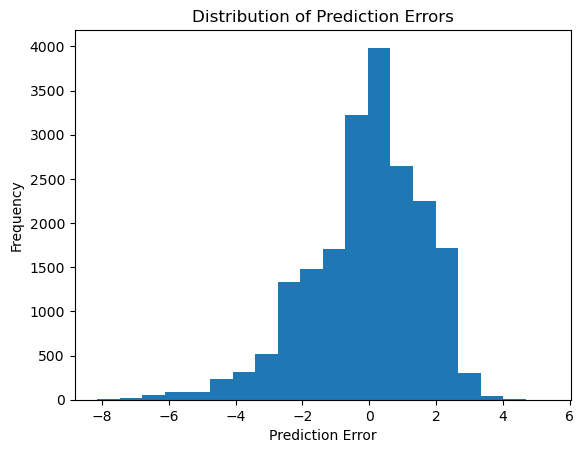

In [165]:
errors = np.array(actual) - np.array(predicted)
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

Text(0.5, 1.0, 'Distribution of Predicted Ratings')

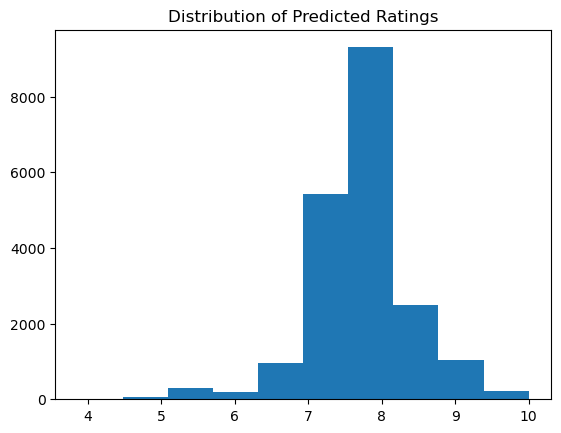

In [167]:
plt.hist(predicted)
plt.title("Distribution of Predicted Ratings")

In [112]:
surprise.model_selection.cross_validate(svd_model, data_surprise, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6975  1.6889  1.6988  1.6832  1.6905  1.6918  0.0058  
MAE (testset)     1.3223  1.3205  1.3242  1.3027  1.3146  1.3169  0.0078  
Fit time          3.20    3.18    3.24    3.28    3.23    3.23    0.04    
Test time         0.13    0.12    0.57    0.13    0.12    0.22    0.18    


{'test_rmse': array([1.69749699, 1.68890797, 1.69878213, 1.68315579, 1.69054879]),
 'test_mae': array([1.32229379, 1.32053902, 1.32417735, 1.30272318, 1.31455654]),
 'fit_time': (3.2013814449310303,
  3.1752026081085205,
  3.238792657852173,
  3.284041166305542,
  3.230332851409912),
 'test_time': (0.1268022060394287,
  0.12233424186706543,
  0.5740795135498047,
  0.13158178329467773,
  0.12096738815307617)}

## Get recommendations

In [129]:
def recommend(user_id,num_of_recommendation = 10):
    all_items = data['ISBN'].unique()
    # predict ratings for all items
    predicted_ratings = [svd_model.predict(user_id, ISBN).est for ISBN in all_items]
    # create a list of item and their predictive rating
    isbn_rating = list(zip(all_items, predicted_ratings))
    isbn_rating.sort(key= lambda x: x[1], reverse=True)
    #get number of recommendations
    top_rec = isbn_rating[:num_of_recommendation]
    #get titles
    top_rec_title =[(book_title_map[ISBN], rating) for ISBN, rating in top_rec]
    return top_rec_title

In [154]:
user_id =154811
recommendations = recommend(user_id, 10)
recommendations
print("Top 10 Recommendations for user {}:".format(user_id))
for title, rating in recommendations:
    print(f"{title}: Predicted Rating: {rating:.2f}")

Top 10 Recommendations for user 154811:
Harry Potter and the Prisoner of Azkaban (Book 3): Predicted Rating: 8.93
The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2): Predicted Rating: 8.84
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)): Predicted Rating: 8.84
Ender's Game (Ender Wiggins Saga (Paperback)): Predicted Rating: 8.83
The Perks of Being a Wallflower: Predicted Rating: 8.71
To Kill a Mockingbird: Predicted Rating: 8.66
Harry Potter and the Sorcerer's Stone (Book 1): Predicted Rating: 8.64
Griffin &amp; Sabine: An Extraordinary Correspondence: Predicted Rating: 8.62
Harry Potter and the Chamber of Secrets (Book 2): Predicted Rating: 8.61
Lonesome Dove: Predicted Rating: 8.59
